### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
warnings.filterwarnings('ignore')

# Download necessary NLTK data (first time only)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load all the files from the kaggle and unzip the dataset.

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews
!unzip amazonreviews.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 99% 489M/493M [00:02<00:00, 225MB/s]
100% 493M/493M [00:02<00:00, 194MB/s]
Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            label, review = line.strip().split(maxsplit=1)
            yield label, review

In [ ]:
def get_labels_and_reviews(file):
    labels = []
    reviews = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        reviews.append(x[10:].strip())
    return np.array(labels), reviews

In [ ]:
train_label, train_review = get_labels_and_reviews('/content/train.ft.txt.bz2')
df_train = pd.DataFrame({'label': train_label, 'review': train_review})

In [ ]:
test_label, test_review = get_labels_and_reviews('/content/test.ft.txt.bz2')
df_test = pd.DataFrame({'label': test_label, 'review': test_review})

### Visualize the dataset before cleaning

In [ ]:
df_train.head()

,label,review
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


In [ ]:
df_train.shape

(3600000, 2)

In [ ]:
df_test.shape

(400000, 2)

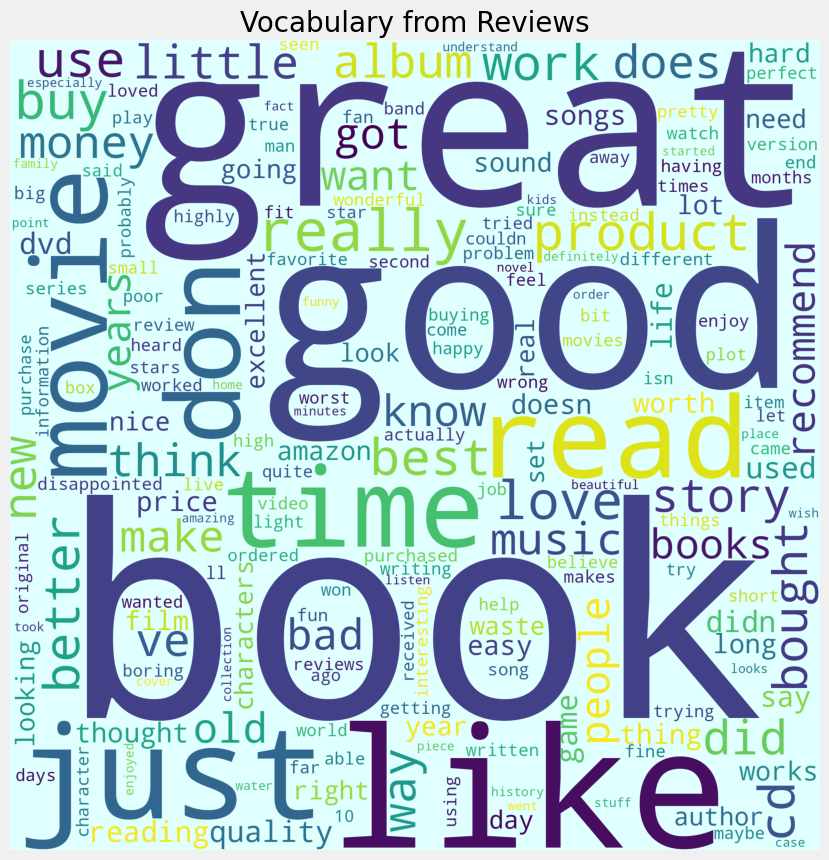

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train.review)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

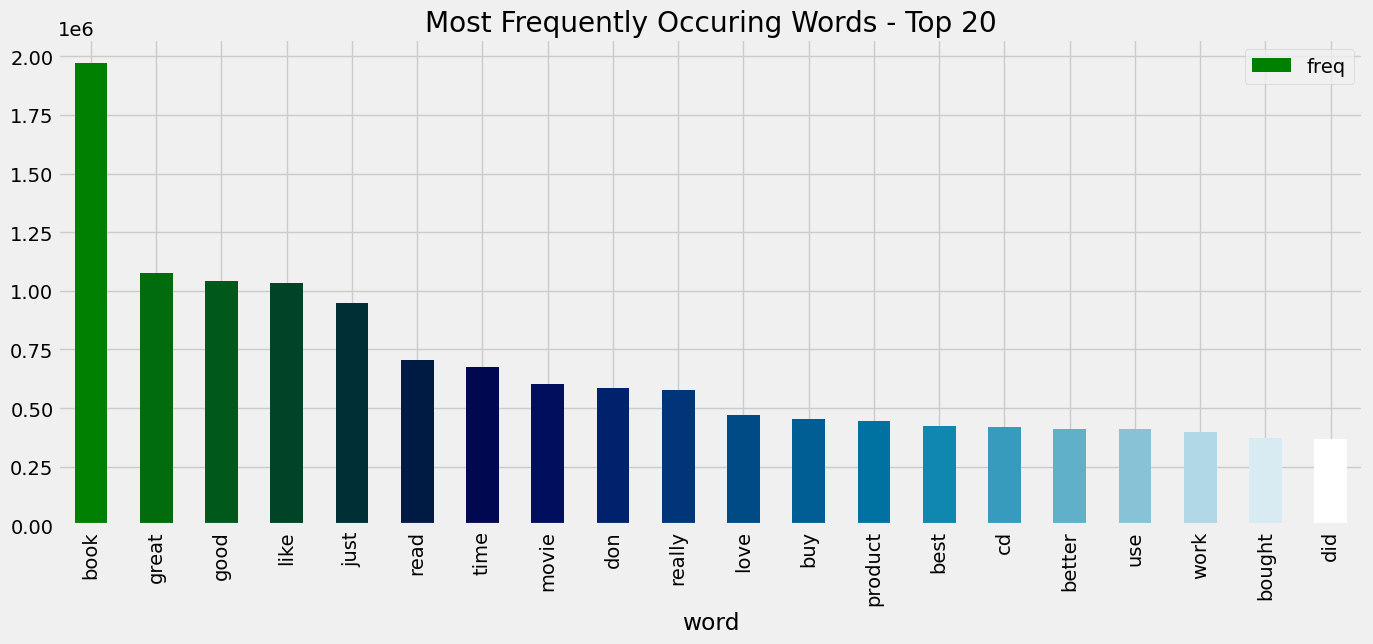

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train.review)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

<Axes: ylabel='proportion'>

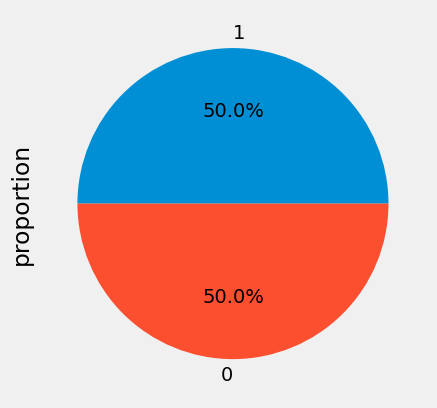

In [ ]:
df_train['label'].value_counts(normalize=True).plot(kind='pie',autopct='%0.1f%%')

<Axes: ylabel='proportion'>

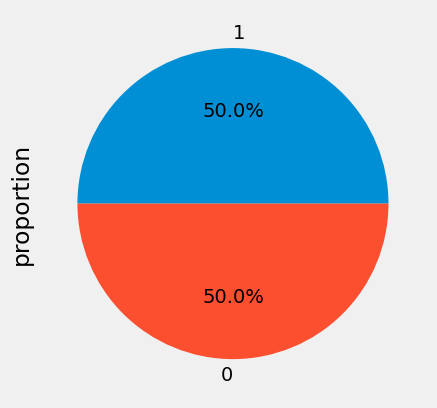

In [ ]:
df_test['label'].value_counts(normalize=True).plot(kind='pie',autopct='%0.1f%%')

In [ ]:
df_train["review"][0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [ ]:
df_test["review"][0]

'Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"'

### Clean the datasets and Do Preprocessing on it.

In [ ]:
def clean_data(text):
    return ' '.join(re.sub("(@[a-zA-Z0-9]+)|([^0-9A-Za-z])|(https://[\w.]+/[\w]+)", " ", text).split())

In [ ]:
df_train['review'] = df_train['review'].apply(clean_data)
df_test['review'] = df_test['review'].apply(clean_data)

In [ ]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

In [ ]:
df_train['review'] = df_train['review'].apply(drop_numbers)
df_test['review'] = df_test['review'].apply(drop_numbers)

In [ ]:
def lower_case(text):
    text_words = word_tokenize(text)
    text_words_lower = [x.lower() for x in text_words]
    return ' '.join(text_words_lower)

In [ ]:
df_train['review'] = df_train['review'].apply(lower_case)
df_test['review'] = df_test['review'].apply(lower_case)

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatise(text):
    text_tokens = word_tokenize(text)
    text_lemm = [lemmatizer.lemmatize(word) for word in text_tokens]
    return ' '.join(text_lemm)

In [ ]:
df_train['review'] = df_train['review'].apply(lemmatise)
df_test['review'] = df_test['review'].apply(lemmatise)

In [ ]:
df_train = df_train[(df_train['review'].isnull()) == False]
df_test = df_test[(df_test['review'].isnull()) == False]

In [ ]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

stopwords_set = set(stopwords.words('english'))

def remove_stopword(text):
    if not isinstance(text, str):
        return text
    text_tokens = word_tokenize(text)
    tokens = [word for word in text_tokens if word not in stopwords_set]
    return ' '.join(tokens)

def parallel_apply(df_column, func):
    with Pool(cpu_count()) as pool:
        result = list(tqdm(pool.imap_unordered(func, df_column), total=len(df_column), desc="Processing"))
    return result



In [ ]:
df_train['review'] = parallel_apply(df_train['review'], remove_stopword)
df_test['review'] = parallel_apply(df_test['review'], remove_stopword)

Processing: 100%|██████████| 399999/399999 [04:47<00:00, 1390.32it/s]


In [ ]:
df_train["review"][0]

'best soundtrack ever anything reading lot review saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening year beauty simply refuse fade price tag pretty staggering must say going buy cd much money one feel would worth every penny'

In [ ]:
df_test["review"][0]

'one best game music soundtrack game really play despite fact played small portion game music heard plus connection chrono trigger wa great well led purchase soundtrack remains one favorite album incredible mix fun epic emotional song sad beautiful track especially like many kind song video game soundtrack must admit one song life distant promise ha brought tear eye many occasion one complaint soundtrack use guitar fretting effect many song find distracting even included would still consider collection worth'

In [5]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load("/content/drive/My Drive/word2vec-google-news-300.model")

In [7]:
from tqdm import tqdm
def convert_to_embedding(reviews, max_words=100, batch_size=100000):
    def process_batch(batch):
        return [
            np.mean(
                [word2vec_model[word] for word in review.split()[:max_words] if word in word2vec_model],
                axis=0
            ) if any(word in word2vec_model for word in review.split()[:max_words]) else np.zeros(300)
            for review in batch
        ]

    embeddings = []
    for i in tqdm(range(0, len(reviews), batch_size), desc="Converting reviews to embeddings"):
        batch = reviews[i:i + batch_size]
        embeddings.extend(process_batch(batch))

    return embeddings


In [8]:
df_train_embedding = convert_to_embedding(df_train['review'])
df_test_embedding = convert_to_embedding(df_test['review'])

Converting reviews to embeddings: 100%|██████████| 4/4 [00:41<00:00, 10.28s/it]
